In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
precision = [np.arange(10) for _ in range(4)]
recall = [np.arange(9, -1, -1) for _ in range(4)]

In [6]:
precision

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

In [7]:
recall

[array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
 array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
 array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
 array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])]

In [9]:
np.mean(precision, axis=0)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

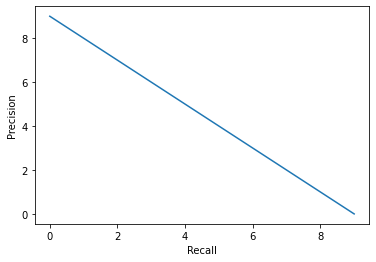

In [37]:
fig, ax = plt.subplots()
sns.lineplot(x=recall, y=precision, ax=ax)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.show()

In [38]:
np.mean([1, 2, 3, 4])

2.5